# Homework with Hacker News data (Solution)

## About Hacker News

[Hacker News](https://news.ycombinator.com/) is a popular "social news" website run by the startup incubator Y Combinator. It primarily includes news about technology, but also includes job postings and community-generated questions.

Any user can [submit](https://news.ycombinator.com/submit) a post to Hacker News. There are two types of posts: articles and discussions. To submit an **article**, the user includes a title and a URL. To submit a **discussion**, the user includes a title and additional text.

Users can upvote posts that they find interesting. Every post starts at 1 point, and each upvote adds an additional point. The most popular recent posts appear on the front page of Hacker News.

## Description of the data

A [dataset of Hacker News posts](https://www.kaggle.com/hacker-news/hacker-news-posts) is hosted on Kaggle Datasets. It includes about one year of data, ending in September 2016. The following fields are included in the dataset:

- **title:** title of the post
- **url:** URL of the post (if any)
- **num_points:** number of points that the post received
- **num_comments:** number of user comments on the post
- **author:** name of the user that submitted the post
- **created_at:** date and time the post was submitted

## Problem statement

Your goal is to predict the likelihood that a post will be "popular", based on the data that is available at the time the post is submitted.

## Tasks

1. Get the data
2. Prepare the data
3. Explore the training data
4. Feature engineering
5. Define **`make_features()`**
6. Evaluate your model using cross-validation
7. Tune your model using grid search
8. Make predictions for the new data
9. Use text as the input data instead

In [1]:
# for Python 2: use print only as a function
from __future__ import print_function

## Task 1: Get the data

1. Go to the [Kaggle Datasets](https://www.kaggle.com/hacker-news/hacker-news-posts) page, and click the **Download** button.
2. Unzip **`hacker-news-posts.zip`**, and then move **`HN_posts_year_to_Sep_26_2016.csv`** to a directory where you can easily access it.
3. Read the file into a pandas DataFrame called **"hn"**.
4. Either during or after the file reading process, convert the **created_at** column to datetime format.

    - **Hint:** [How do I work with dates and times in pandas?](https://www.youtube.com/watch?v=yCgJGsg0Xa4&list=PL5-da3qGB5ICCsgW1MxlZ0Hq8LL5U3u9y&index=25) explains how to do this.

In [2]:
import pandas as pd

In [3]:
# define 'id' as the index and convert 'created_at' to datetime format
hn = pd.read_csv('../data/HN_posts_year_to_Sep_26_2016.csv', index_col='id', parse_dates=['created_at'])
hn.dtypes

title                   object
url                     object
num_points               int64
num_comments             int64
author                  object
created_at      datetime64[ns]
dtype: object

## Task 2: Prepare the data

1. Create a new column called **"popular"** that contains **1** if the post received more than 5 points, and **0** otherwise. This will be the response variable that you are trying to predict.
2. Split the **hn** DataFrame into two separate DataFrames. The first DataFrame should be called **"train"**, and should contain all posts before July 1, 2016. The second DataFrame should be called **"new"**, and should contain the remaining posts.

    - **Hint:** [How do I work with dates and times in pandas?](https://www.youtube.com/watch?v=yCgJGsg0Xa4&list=PL5-da3qGB5ICCsgW1MxlZ0Hq8LL5U3u9y&index=25) explains how to do this. Make sure that all rows from **hn** are in either **train** or **new**, but not both.
    - **Hint:** When you are creating **train** and **new**, you should use the [`DataFrame.copy()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.copy.html) method to make sure that you are creating separate objects (rather than references to the **hn** DataFrame).
    - **Note:** You will be building a model using the posts in **train** and making predictions for the posts in **new** (our simulated future data).

In [4]:
# create the response variable
hn['popular'] = (hn.num_points > 5).astype(int)

In [5]:
# check the earliest and latest times in the dataset
print(hn.created_at.min())
print(hn.created_at.max())

2015-09-06 05:50:00
2016-09-26 03:26:00


In [6]:
# count the number of rows
hn.shape[0]

293119

In [7]:
# create a timestamp of July 1 at midnight
july_1 = pd.to_datetime('7/1/2016')
july_1

Timestamp('2016-07-01 00:00:00')

In [8]:
# explicitly copy 'hn' when creating 'train' and 'new'
train = hn[hn.created_at < july_1].copy()
new = hn[hn.created_at >= july_1].copy()

In [9]:
# confirm that 'train' and 'new' together contain all the rows from 'hn'
train.shape[0] + new.shape[0]

293119

## Task 3: Explore the training data

Explore the **train** DataFrame to gain an understanding of the dataset.

**Note:** At no time should you explore the **new** DataFrame, since this is our simulated future data which you would not have access to in the "real world".

In [10]:
train.head()

,title,url,num_points,num_comments,author,created_at,popular
id,,,,,,,
12012874,The Master JavaScript Course Has Been Released...,http://www.masterjavascript.io/lp/master-javas...,1,1,erikgrueter,2016-06-30 23:58:00,0
12012865,Deeply Learn the JavaScript Scope Chain,http://www.masterjavascript.io/blog/2016/05/22...,2,0,erikgrueter,2016-06-30 23:57:00,0
12012863,Deeply Learning JavaScript Closures,http://www.masterjavascript.io/blog/2016/04/24...,2,0,erikgrueter,2016-06-30 23:57:00,0
12012861,You want more than product/market fit,https://justinjackson.ca/want/,4,0,wocg,2016-06-30 23:57:00,0
12012859,What's the Best Way to Learn JavaScript???,http://www.masterjavascript.io/blog/2016/06/05...,1,0,erikgrueter,2016-06-30 23:56:00,0


In [11]:
train.tail()

,title,url,num_points,num_comments,author,created_at,popular
id,,,,,,,
10176919,Ask HN: What is/are your favorite quote(s)?,NaN,15,20,kumarski,2015-09-06 06:02:00,1
10176917,Attention and awareness in stage magic: turnin...,http://people.cs.uchicago.edu/~luitien/nrn2473...,14,0,stakent,2015-09-06 06:01:00,1
10176908,Dying vets fuck you letter (2013),http://dangerousminds.net/comments/dying_vets_...,10,2,mycodebreaks,2015-09-06 05:56:00,1
10176907,"PHP 7 Coolest Features: Space Ships, Type Hint...",https://www.zend.com/en/resources/php-7,2,0,Garbage,2015-09-06 05:55:00,0
10176903,Toyota Establishes Research Centers with MIT a...,http://newsroom.toyota.co.jp/en/detail/9233109/,4,0,tim_sw,2015-09-06 05:50:00,0


In [12]:
# check for missing values
train.isnull().sum()

title               0
url             10560
num_points          0
num_comments        0
author              0
created_at          0
popular             0
dtype: int64

In [13]:
# examine posts that contain missing 'url' values
train[train.url.isnull()].head()

,title,url,num_points,num_comments,author,created_at,popular
id,,,,,,,
12012038,Let us code,NaN,1,0,Edmond,2016-06-30 21:45:00,0
12011714,Ask HN: Google Voice as the main phone solutio...,NaN,1,6,dhruvkar,2016-06-30 21:06:00,0
12011708,Ask HN: How Did You Start Over?,NaN,16,5,artur_makly,2016-06-30 21:05:00,1
12011278,What Is Happening with Web Components and Polymer,NaN,2,2,nemanjapopovic,2016-06-30 20:09:00,0
12011192,Ask HN: Taking a job I feel under qualified for?,NaN,2,4,newyearnewyou,2016-06-30 19:55:00,0


In [14]:
# note that the mean is much greater than the median due to extreme outliers
train.num_points.describe()

count    229000.000000
mean         14.879712
std          58.340932
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        5771.000000
Name: num_points, dtype: float64

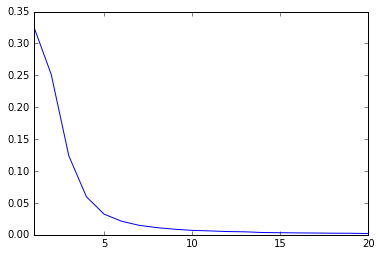

In [15]:
# plot the percentage of posts with a particular 'num_points'
%matplotlib inline
train.num_points.value_counts(normalize=True)[0:20].plot()

In [16]:
# check the class distribution
train.popular.value_counts(normalize=True)

0    0.794738
1    0.205262
Name: popular, dtype: float64

In [17]:
# examine the highest rated posts
train.sort_values('num_points', ascending=False).head()

,title,url,num_points,num_comments,author,created_at,popular
id,,,,,,,
11116274,A Message to Our Customers,http://www.apple.com/customer-letter/,5771,967,epaga,2016-02-17 08:38:00,1
11966167,UK votes to leave EU,http://www.bbc.co.uk/news/uk-politics-36615028,3125,2531,dmmalam,2016-06-24 03:48:00,1
11390545,Ubuntu on Windows,http://blog.dustinkirkland.com/2016/03/ubuntu-...,2049,513,bpierre,2016-03-30 16:35:00,1
11893153,Microsoft to acquire LinkedIn for $26B,http://news.microsoft.com/2016/06/13/microsoft...,2049,831,whatok,2016-06-13 12:34:00,1
11080701,"Physicists Detect Gravitational Waves, Proving...",http://www.nytimes.com/2016/02/12/science/ligo...,2011,483,intull,2016-02-11 15:37:00,1


## Task 4: Feature engineering

Create new features in **train** that you think might be relevant to predicting the response, **popular**. After creating each feature, check whether it is likely to be a useful feature.

For this task, don't use **`CountVectorizer`**. (You will use it in Task 9 instead.)

**Note:** Think very carefully about which features you would be "allowed" to use in the real world. If a feature incorporates future data that would not be available **at the time of post submission**, then it can't be used in your model.

### Title

We'll use the text of the **title** column in Task 9, and so for now we'll just calculate title length:

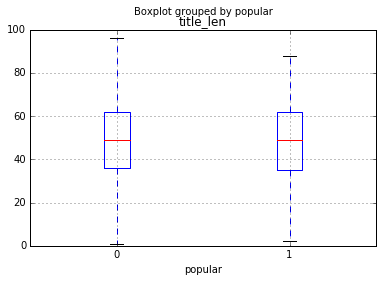

In [18]:
train['title_len'] = train.title.apply(len)
train.boxplot('title_len', by='popular')

This probably won't be a useful feature. However, it looks like posts with very short or very long titles have not been popular in the past. You could try creating a feature to denote posts with extreme title lengths, though that pattern might not generalize to future data.

### URL

Rather than focusing on the contents of the **url** column, we'll first examine the presence or absence of a URL, since that distinguishes articles from discussions:

In [19]:
train['discussion'] = train.url.isnull().astype(int)
train.groupby('discussion').popular.mean()

discussion
0    0.203699
1    0.237595
Name: popular, dtype: float64

We see that 24% of discussion posts are popular, whereas 20% of article posts are popular.

However, there are actually two types of discussion posts: ones that contain "HN" (such as "Ask HN" or "Tell HN") and ones that don't. We'll decompose the **discussion** feature into two more specific features:

In [20]:
train['discussion_hn'] = ((train.url.isnull()) & (train.title.str.contains(' HN: '))).astype(int)
train.groupby('discussion_hn').popular.mean()

discussion_hn
0    0.202916
1    0.274833
Name: popular, dtype: float64

In [21]:
# ~ means 'not', thus it reverses True and False
train['discussion_other'] = ((train.url.isnull()) & (~train.title.str.contains(' HN: '))).astype(int)
train.groupby('discussion_other').popular.mean()

discussion_other
0    0.206051
1    0.147573
Name: popular, dtype: float64

We see that the "HN" discussions are more popular than average, and the "other" discussions are less popular than average. Thus, **discussion_hn** and **discussion_other** are more useful features than **discussion**, since they capture more specific and more extreme effects on the response. (These features could perhaps be decomposed even further.)

Now, we'll move on to the domain extensions:

In [22]:
train['dot_org'] = train.url.str.contains('.org', case=False, na=False, regex=False).astype(int)
train.groupby('dot_org').popular.mean()

dot_org
0    0.202345
1    0.234811
Name: popular, dtype: float64

In [23]:
train['dot_edu'] = train.url.str.contains('.edu', case=False, na=False, regex=False).astype(int)
train.groupby('dot_edu').popular.mean()

dot_edu
0    0.204010
1    0.313913
Name: popular, dtype: float64

In [24]:
train['dot_gov'] = train.url.str.contains('.gov', case=False, na=False, regex=False).astype(int)
train.groupby('dot_gov').popular.mean()

dot_gov
0    0.205069
1    0.238636
Name: popular, dtype: float64

These all seem to be useful features.

We could create more features from the domain name, though that would take more work and could be handled more easily by **`CountVectorizer`**.

### Submission date and time

We'll check whether the day of week a post is submitted affects its popularity:

In [25]:
train['day'] = train.created_at.dt.weekday
train.groupby('day').popular.mean()

day
0    0.205487
1    0.189598
2    0.189134
3    0.192912
4    0.200725
5    0.247203
6    0.261793
Name: popular, dtype: float64

There is a meaningful difference in popularity between weekday posts (0 through 4) and weekend posts (5 and 6). We'll create a simpler feature to capture that trend:

In [26]:
train['weekend'] = (train.day >= 5).astype(int)
train.groupby('weekend').popular.mean()

weekend
0    0.195171
1    0.254465
Name: popular, dtype: float64

We'll also check whether the time of day a post is submitted affects its popularity:

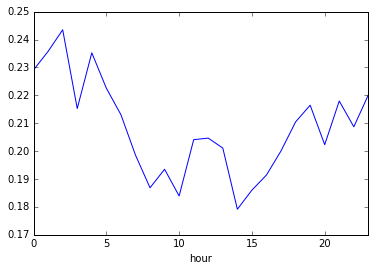

In [27]:
train['hour'] = train.created_at.dt.hour
train.groupby('hour').popular.mean().plot()

We see that posts submitted late at night are more popular than ones submitted during the day. We'll create a feature to capture that trend:

In [28]:
train['late_night'] = ((train.hour <= 5) | (train.hour >= 23)).astype(int)
train.groupby('late_night').popular.mean()

late_night
0    0.199765
1    0.228538
Name: popular, dtype: float64

### Author

We'll examine whether some users are better at submitting popular posts than others:

In [29]:
# create a DataFrame of author data
authors = train.groupby('author').popular.agg(['count', 'mean'])
authors.shape[0]

44057

In [30]:
authors.sort_values('count', ascending=False).head()

,count,mean
author,,
ingve,2119,0.312412
jonbaer,2117,0.137459
prostoalex,1224,0.285948
dnetesn,1212,0.229373
jseliger,935,0.183957


**count** represents the number of posts submitted by that user, and **mean** represents the percentage of those posts that were popular.

We're mainly interested in finding users with a track record of submitting popular posts. So, we'll examine the relationship between **count** and **mean** for users who have submitted at least 10 posts:

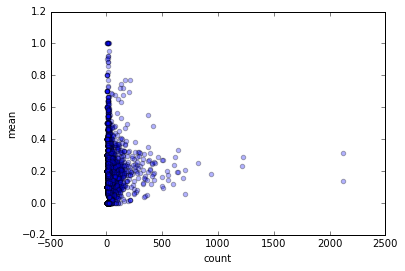

In [31]:
authors[authors['count'] >= 10].plot(kind='scatter', x='count', y='mean', alpha=0.3)

We'll create two features from this data: **smart_authors** are users that submitted at least 10 posts and at least 50% were popular, and **frequent_authors** are users that submitted at least 100 posts and at least 30% were popular:

In [32]:
smart_authors = authors[(authors['count'] >= 10) & (authors['mean'] >= 0.5)]
smart_authors.shape[0]

153

In [33]:
smart_authors.head()

,count,mean
author,,
0xAX,17,0.588235
13375p33dp0573r,11,0.818182
BobbyVsTheDevil,14,1.000000
EddieRingle,11,0.636364
GolDDranks,12,0.500000


In [34]:
# check whether the author of each post in 'train' is in 'smart_authors'
train['smart_author'] = train.author.isin(smart_authors.index).astype(int)
train.groupby('smart_author').popular.mean()

smart_author
0    0.197386
1    0.644913
Name: popular, dtype: float64

In [35]:
frequent_authors = authors[(authors['count'] >= 100) & (authors['mean'] >= 0.3)]
frequent_authors.shape[0]

48

In [36]:
frequent_authors.head()

,count,mean
author,,
ColinWright,205,0.326829
DrScump,162,0.327160
Hooke,135,0.748148
Jerry2,387,0.310078
Thevet,166,0.771084


In [37]:
# check whether the author of each post in 'train' is in 'frequent_authors'
train['frequent_author'] = train.author.isin(frequent_authors.index).astype(int)
train.groupby('frequent_author').popular.mean()

frequent_author
0    0.195260
1    0.399625
Name: popular, dtype: float64

Finally, we'll create an **author_popularity** feature that calculates the percentage of each user's posts that were popular, regardless of how many posts they submitted:

In [38]:
# 'mean' represents the percentage of popular posts for each user
authors['mean'].head()

author
0-o        0.000000
001sky     0.171429
00_NOP     0.000000
00__00     0.000000
00taffe    0.000000
Name: mean, dtype: float64

In [39]:
# map the author of each post to their popularity
train['author_popularity'] = train.author.map(authors['mean'])

Note that if **author_popularity** is included in the model when using cross-validation (Task 6), the cross-validated performance estimate will be highly skewed. Why? Because **author_popularity** was calculated on the entire training set (which will be passed to cross-validation), and thus it incorporates information about the future. In other words, cross-validation is trying to simulate an unknown future during each iteration, yet the model will have knowledge about that future.

For example, let's pretend that there is a user "kevin" who has submitted 2 posts, and neither of those posts were popular. Thus, his **author_popularity** is 0. During 5-fold cross-validation, let's say that one of his posts appears in the testing portion (the one-fifth that is set aside) during the first iteration. Given that the **author_popularity** for that post is 0, and given that **author_popularity** was calculated on the entire training set, the model will be able to predict with 100% certainty that that post was not popular.

To be clear, **author_popularity** is a perfectly legitimate feature that we are allowed to use when making predictions for new data. However, the only way to properly cross-validate this feature (to estimate whether it will generalize to new data) is to create this feature during each iteration of cross-validation.

Now, what about **smart_author** and **frequent_author**? Won't those features similarly skew the cross-validation results, since they were calculated on the entire training set? In my estimation, the answer is no. Why? Because even if those features were created during cross-validation, the contents of those features (for nearly all users) will be identical to the features that were created using the entire training set.

### Number of comments

We are not allowed to use **num_comments** as a feature. Why? Because we are predicting the likelihood a post is popular based only on the data that is available at the time of post submission, and (obviously) comments won't be posted until after the post has been submitted.

As you can imagine, the number of comments is highly predictive of the popularity of a post:

In [40]:
train.groupby('popular').num_comments.describe().unstack()

,count,mean,std,min,25%,50%,75%,max
popular,,,,,,,,
0,181995.0,0.261205,0.911374,0.0,0.0,0.0,0.0,54.0
1,47005.0,29.978109,60.127437,0.0,1.0,6.0,34.0,2531.0


### Number of points

We are not allowed to use **num_points** as a feature. Why? Because that is how we calculated whether or not a post is popular, and thus it is perfectly predictive of the popularity of a post:

In [41]:
train.groupby('popular').num_points.agg(['min', 'max'])

,min,max
popular,,
0,1,5
1,6,5771


## Task 5: Define **`make_features()`**

1. Define a function, **`make_features()`**, that accepts a DataFrame and returns a DataFrame with your engineered features added. You should only include features that you think might be useful for predicting popularity.
2. Re-split the **hn** DataFrame into **train** and **new** (using the code from Task 2) to return them to their original contents.
3. Run **`make_features()`** on **train** and **new**, and check that your features were successfully created.

In [42]:
def make_features(df):
    
    df['discussion_hn'] = ((df.url.isnull()) & (df.title.str.contains(' HN: '))).astype(int)
    df['discussion_other'] = ((df.url.isnull()) & (~df.title.str.contains(' HN: '))).astype(int)
    
    df['dot_org'] = df.url.str.contains('.org', case=False, na=False, regex=False).astype(int)
    df['dot_edu'] = df.url.str.contains('.edu', case=False, na=False, regex=False).astype(int)
    df['dot_gov'] = df.url.str.contains('.gov', case=False, na=False, regex=False).astype(int)
    
    df['weekend'] = (df.created_at.dt.weekday >= 5).astype(int)
    df['late_night'] = ((df.created_at.dt.hour <= 5) | (df.created_at.dt.hour >= 23)).astype(int)
    
    df['smart_author'] = df.author.isin(smart_authors.index).astype(int)
    df['frequent_author'] = df.author.isin(frequent_authors.index).astype(int)
    df['author_popularity'] = df.author.map(authors['mean'])
    
    # author_popularity will be missing in 'new' for any users that never appeared in 'train', so fill with 0.2
    df.author_popularity.fillna(0.2, inplace=True)
    
    return df

In [43]:
# return 'train' and 'new' to their original contents
train = hn[hn.created_at < july_1].copy()
new = hn[hn.created_at >= july_1].copy()

In [44]:
train = make_features(train)
new = make_features(new)

## Task 6: Evaluate your model using cross-validation

1. Define **X** and **y** using your chosen feature columns from **train**.
2. Choose a classification model, and then use **`cross_val_score`** to evaluate your model. We're going to use AUC as the evaluation metric, so use the parameter **`scoring='roc_auc'`**.
3. **Optional:** Try adding features to your model that would not be "allowed" in the real world (because they incorporate information about the future), and see how that affects your AUC. (Be sure to remove these features from your model before moving on to the next task!)

    - **Note:** An AUC of 1.0 represents a perfect model, and an AUC of 0.5 represents random guessing. You can think of 0.5 as the AUC of the "null model". (My [blog post and video](http://www.dataschool.io/roc-curves-and-auc-explained/) explain AUC in more depth.)

In [45]:
# include all engineered features (except 'author_popularity')
feature_cols = list(train.columns[7:-1])
feature_cols

['discussion_hn',
 'discussion_other',
 'dot_org',
 'dot_edu',
 'dot_gov',
 'weekend',
 'late_night',
 'smart_author',
 'frequent_author']

In [46]:
X = train[feature_cols]
y = train.popular

In [47]:
from sklearn.cross_validation import cross_val_score

In [48]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
cross_val_score(logreg, X, y, cv=5, scoring='roc_auc').mean()

0.57715947267768652

As mentioned in Task 4, including **author_popularity** in the model will skew the cross-validation results (though it is a legitimate feature). In addition, we're not allowed to use **num_comments** or **num_points** as features. Let's try adding these features one at a time, and see how that affects the AUC:

In [49]:
unfair_features = ['author_popularity', 'num_comments', 'num_points']
for feature in unfair_features:
    X_unfair = train[feature_cols + [feature]]
    auc = cross_val_score(logreg, X_unfair, y, cv=5, scoring='roc_auc').mean()
    print('\nFeature: ' + feature)
    print('AUC:     ' + str(auc))


Feature: author_popularity
AUC:     0.82175777286

Feature: num_comments
AUC:     0.871220291452

Feature: num_points
AUC:     1.0


## Task 7: Tune your model using grid search

Use **`GridSearchCV`** to find the optimal tuning parameters for your model.

In [50]:
from sklearn.grid_search import GridSearchCV

In [51]:
# define a parameter grid of the "important" tuning parameters
param_grid = {}
param_grid['penalty'] = ['l1', 'l2']
param_grid['C'] = [0.1, 1.0, 10]

In [52]:
# run the grid search and examine the scores
grid = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc')
grid.fit(X, y)
grid.grid_scores_

[mean: 0.57707, std: 0.01178, params: {'penalty': 'l1', 'C': 0.1},
 mean: 0.57714, std: 0.01185, params: {'penalty': 'l2', 'C': 0.1},
 mean: 0.57715, std: 0.01185, params: {'penalty': 'l1', 'C': 1.0},
 mean: 0.57716, std: 0.01187, params: {'penalty': 'l2', 'C': 1.0},
 mean: 0.57716, std: 0.01187, params: {'penalty': 'l1', 'C': 10},
 mean: 0.57716, std: 0.01187, params: {'penalty': 'l2', 'C': 10}]

In [53]:
# examine the score and parameters of the best model
print(grid.best_score_)
print(grid.best_params_)

0.577159472678
{'penalty': 'l2', 'C': 1.0}


## Task 8: Make predictions for the new data

1. Create a DataFrame called **"X_new"** that includes the same feature columns you used to train your model.
2. Train your best model (found during grid search) using **X** and **y**.
3. Calculate the predicted probability of popularity for all posts in **X_new**.
4. Calculate the AUC of your model by evaluating your predicted probabilities against the **popular** column in the **new** DataFrame. (It should be similar to the AUC that was output by **`GridSearchCV`**.)

    - **Hint:** [Evaluating a classification model](https://github.com/justmarkham/scikit-learn-videos/blob/master/09_classification_metrics.ipynb) explains how to calculate predicted probabilities and AUC.

In [54]:
# create a DataFrame of feature columns from the new data
X_new = new[feature_cols]

In [55]:
# train the best model using X and calculate predicted probabilities for X_new
logreg = LogisticRegression(penalty='l2', C=1.0)
logreg.fit(X, y)
new_pred_prob = logreg.predict_proba(X_new)[:, 1]
new_pred_prob

array([ 0.23065636,  0.21568012,  0.19198775, ...,  0.27412378,
        0.27412378,  0.19198775])

In [56]:
# shortcut: GridSearchCV automatically refits the best model with the entire dataset, and can be used to make predictions
new_pred_prob = grid.predict_proba(X_new)[:, 1]
new_pred_prob

array([ 0.23065636,  0.21568012,  0.19198775, ...,  0.27412378,
        0.27412378,  0.19198775])

In [57]:
# calculate the AUC on the new data
from sklearn import metrics
metrics.roc_auc_score(new.popular, new_pred_prob)

0.55818346157481014

The AUC on the new data (0.558) is slightly lower than the AUC estimated by cross-validation in Task 7 (0.577). This is normal, and usually indicates that there are differences between the characteristics of past data and future data. In other words, things change over time! :)

Let's try adding **author_popularity** to the model, and see if that improves the AUC on the new data:

In [58]:
# redefine X and X_new to include 'author_popularity'
X = train[feature_cols + ['author_popularity']]
X_new = new[feature_cols + ['author_popularity']]

In [59]:
# retrain and reevaluate the model
logreg.fit(X, y)
new_pred_prob = logreg.predict_proba(X_new)[:, 1]
metrics.roc_auc_score(new.popular, new_pred_prob)

0.58274424037659367

## Task 9: Use text as the input data instead

1. Define a new **X** using the **title** column from **train**.
2. Create a **`Pipeline`** of **`CountVectorizer`** and the model of your choice.
3. Use **`cross_val_score`** to properly evaluate the AUC of your pipeline.
4. **Optional:** See if you can increase the AUC by changing what you use as the input text.
5. Train the pipeline on **X** and **y**, calculate predicted probabilities for all posts in the **new** DataFrame, and calculate the AUC.

In [60]:
# use 'title' as the input text
X = train.title
y = train.popular

In [61]:
# create a pipeline of CountVectorizer and Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
vect = CountVectorizer()
nb = MultinomialNB()
pipe = make_pipeline(vect, nb)

In [62]:
# cross-validate the entire pipeline
cross_val_score(pipe, X, y, cv=5, scoring='roc_auc').mean()

0.593508061947146

In [63]:
# use both 'title' and 'author' as the input text
train['title_author'] = train.title.str.cat(train.author, sep=' ')
new['title_author'] = new.title.str.cat(new.author, sep=' ')

In [64]:
# reevaluate the pipeline
X = train.title_author
y = train.popular
cross_val_score(pipe, X, y, cv=5, scoring='roc_auc').mean()

0.62375088540403612

Using the **title** alone resulted in an AUC of 0.594, and adding the **author** increased the AUC to 0.624! (It's likely that the pipeline could be tuned for even better performance.)

In [65]:
# make predictions for the new data using the pipeline and calculate the AUC
X_new = new.title_author
pipe.fit(X, y)
new_pred_prob = pipe.predict_proba(X_new)[:, 1]
metrics.roc_auc_score(new.popular, new_pred_prob)

0.61360631857516035

As expected, the AUC on the new data (0.614) is slightly lower than the AUC estimated by cross-validation (0.624).